In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pickle
import starry
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from tqdm import tqdm
from scipy.signal import savgol_filter
import os
homedir = os.path.expanduser('~')

/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
firstchip = 4
nobs, nchip, npix = 14, 2, 1848
resultdir = f'starry_IGRINS/order{firstchip}+{nchip}_nocors_'

In [48]:
# Load the dataset
with open(f'{homedir}/uoedrive/result/CIFIST/IGRINS_W1049B_K_lte015.0-5.0.pickle', "rb") as f:
    data = pickle.load(f, encoding="latin1")
# Timestamps (from Ian Crossfield)
t = np.array([
        0.0,
        0.384384,
        0.76825872,
        1.15339656,
        1.5380364,
        1.92291888,
        2.30729232,
        2.69268336,
        3.07654752,
        3.46219464,
        3.8473428,
        4.23171624,
        4.61583456,
        4.99971048,])
# Use the first epoch's wavelength array
lams = data["chiplams"][0]
# Interpolate onto that array
observed = np.empty((nobs, nchip, npix))
template = np.empty((nobs, nchip, npix))
broadened = np.empty((nobs, nchip, npix))
for k in range(nobs):
    for c in range(nchip):
        observed[k][c] = np.interp(lams[c+firstchip], 
            data["chiplams"][k][c+firstchip],
            data["fobs0"][k][c+firstchip] #/ data["chipcors"][k][c+firstchip],
        )
        template[k][c] = np.interp(lams[c+firstchip],
            data["chiplams"][k][c+firstchip],
            data["chipmodnobroad"][k][c+firstchip] #/ data["chipcors"][k][c+firstchip],
        )
        broadened[k][c] = np.interp(lams[c+firstchip],
            data["chiplams"][k][c+firstchip],
            data["chipmods"][k][c+firstchip] #/ data["chipcors"][k][c+firstchip],
        )

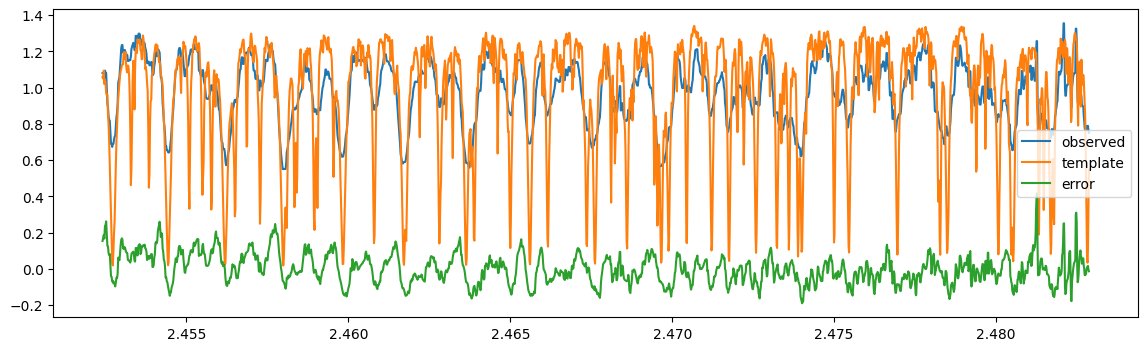

In [49]:
# Smooth the data and compute the median error from the MAD
smoothed = np.array(
    [savgol_filter(np.mean(observed[:, c], axis=0), 19, 3) for c in range(nchip)]
)
resid = observed - smoothed
error = 1.4826 * np.median(np.abs(resid - np.median(resid)))

plt.figure(figsize=(14,4))
k, c = 0, 0
plt.plot(lams[c], observed[k,c,:], label="observed")
#plt.plot(lams[c], smoothed[c,:], label="smoothed")
plt.plot(lams[c], template[k,c,:], label="template")
#plt.plot(lams[c], broadened[k,c,:], label="broadened")
plt.plot(lams[c], resid[k,c,:], label="error")
plt.legend()

In [51]:
# Clip outliers aggressively
level = 4
mask = np.abs(resid) < level * error
mask = np.min(mask, axis=0)

# Get the final data arrays
pad = 100
wav = [None for n in range(nchip)]
wav0 = [None for n in range(nchip)]
flux = [None for n in range(nchip)]
mean_spectrum = [None for n in range(nchip)]
for c in range(nchip):
    wav[c] = lams[c][:][pad:-pad]
    flux[c] = observed[:, c][:, :][:, pad:-pad]
    wav0[c] = lams[c][:]
    mean_spectrum[c] = np.mean(template[:, c][:, :], axis=0)

In [52]:
# Set up a pymc3 model so we can optimize
with pm.Model() as model:
    # Dimensions
    ydeg = 10
    udeg = 1
    nc = 1
    nt = 14
    # Regularization
    flux_err = 0.02  # Eyeballed; doesn't matter too much since we're not doing posterior inference
    spectrum_sigma = 5e-2  # Hand-tuned; increase this to allow more departure from the template spectrum
    # Fixed
    vsini_max = 30000.0
    period = pm.math.constant(4.9)  # Crossfield et al. (2014)
    inc = pm.math.constant(70.0)  # Crossfield et al. (2014)
    # Free
    vsini = pm.Normal("vsini", mu=26100.0, sd=200)  # Crossfield et al. (2014)
    u1 = pm.Uniform("u1", 0.0, 1.0)  # Crossfield et al. (2014)
    # Deterministic
    veq = vsini / tt.sin(inc * np.pi / 180)
    theta = 360.0 * t / period
    # The surface map
    A = starry.DopplerMap(ydeg=ydeg).sht_matrix(smoothing=0.075)
    npix = A.shape[1]

    p = pm.Uniform("p", lower=0.0, upper=1.0, shape=(npix,))
    y = tt.dot(A, p)

    # The spectrum in each channel
    spectrum = [None for c in range(nchip)]
    for c in range(nchip):
        spectrum[c] = pm.Normal(
            f"spectrum{c}",
            mu=mean_spectrum[c],
            sd=spectrum_sigma,
            shape=mean_spectrum[c].shape,
        )
    # The continuum renormalization factor
    baseline = pm.Uniform("baseline", 0.3, 3.0, shape=(nt,), testval=0.65)
    # A small per-channel baseline offset
    offset = pm.Normal("offset", 0.0, 0.1, shape=(nchip,))
    # Compute the model & likelihood for each channel
    map = [None for c in range(nchip)]
    flux_model = [None for c in range(nchip)]
    for c in range(nchip):
        # Instantiate a map
        map[c] = starry.DopplerMap(
            ydeg=ydeg,
            udeg=udeg,
            nc=nc,
            veq=veq,
            inc=inc,
            nt=nt,
            wav=wav[c],
            wav0=wav0[c],
            lazy=True,
            vsini_max=vsini_max,
        )
        map[c][1] = u1
        map[c][:, :] = y
        map[c].spectrum = spectrum[c]
        # Compute the model
        flux_model[c] = offset[c] + tt.reshape(baseline, (-1, 1)) * map[c].flux(theta=theta, normalize=False)

        # Likelihood term
        pm.Normal(
            f"obs{c}",
            mu=tt.reshape(flux_model[c], (-1,)),
            sd=flux_err,
            observed=flux[c].reshape(-1,),)

Pre-computing some matrices... Done.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Compiling `RAxisAngle`... Done.
Compiling `pT`... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [53]:
# Optimization settings
lr = 1e-3
niter = 1000

# Optimize!
loss = []
best_loss = np.inf
map_soln = model.test_point
iterator = tqdm(
    pmx.optim.optimize_iterator(pmx.optim.Adam(lr=lr), niter, start=map_soln),
    total=niter,
    disable=os.getenv("CI", "false") == "true",
)
with model:
    for obj, point in iterator:
        iterator.set_description(
            "loss: {:.3e} / {:.3e}".format(obj, best_loss)
        )
        loss.append(obj)
        if obj < best_loss:
            best_loss = obj
            map_soln = point

loss: 5.908e+05 / 5.909e+05: 100%|██████████| 1000/1000 [06:57<00:00,  2.39it/s]


In [73]:
# Plot the MAP map
with model:
    y_map = pmx.eval_in_model(y, point=map_soln)
    inc_map = pmx.eval_in_model(inc, point=map_soln)
map_map = starry.Map(ydeg, inc=inc_map)
map_map[:, :] = y_map
map_map.show(projection="moll", colorbar=True, file=f"{resultdir}luhman16b_map.png")

Pre-computing some matrices... Done.
Compiling `render`... Done.
